# Imports

In [1]:
import matplotlib.pyplot as plt
from os import walk
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np
import IPython.display
from skimage.transform import radon, rescale, resize
import cv2

# Configuration

In [2]:
pic_dir = "./tomograf-zdjecia/"

# Loading and preprocess files

In [3]:
filenames = next(walk(pic_dir), (None, None, []))[2]  # [] if no file
images = dict()

for file in filenames:
    img = cv2.imread(pic_dir+file, cv2.IMREAD_GRAYSCALE)
    
    # fill backgorund
    h, w = img.shape
    diagonal = np.round(np.sqrt(h**2 + w**2)).astype(int)
    new_shape = (diagonal, diagonal)
    large_img = np.zeros(new_shape)
    cx = (diagonal - h) // 2
    cy = (diagonal - w) // 2
    large_img[cy:cy+h, cx:cx+w] = img
    
    images[file.split('.')[0]] = large_img


# Bresenham algorithm

In [4]:
# source: https://eduinf.waw.pl/inf/utils/002_roz/2008_06.php

def bresenham(p1, p2):
    assert isinstance(p1, tuple), "First argument should be tuple"
    assert isinstance(p2, tuple), "Second argument should be tuple"
    
    x1, y1 = p1
    x2, y2 = p2
    pixels = []
    dx = abs(x2-x1)
    dy = abs(y2-y1)
    
    if x1 < x2:
        sx = 1
    else:
        sx = -1
    if y1 < y2:
        sy = 1
    else:
        sy = -1
    err = dx - dy
    
    while True:
        pixels.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy
    
    return pixels


print(bresenham((2,2), (-1,-1)))

[(2, 2), (1, 1), (0, 0), (-1, -1)]


# Radon Transform
#### Using scikit-image function

In [5]:
n = 1 # liczba detektorów
l = 1 # rozpiętość układu emitter/detektor

@interact
def ranon_transform(image=list(images.keys()),
                    n=widgets.IntSlider(min=90,max=720,step=90,value=180),
                    l=widgets.IntSlider(min=45,max=270,step=45,value=180)):
    
    img  = rescale(images[image], scale=0.2, mode='reflect', channel_axis=None)
    img = np.resize(img, (img.shape[0], img.shape[1]))
    img = img / 255.
    
    sinogram = radon(img)
    plt.imshow(sinogram, cmap='gray')
    plt.show()


interactive(children=(Dropdown(description='image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-l…

# Radon transform
#### Our implementation (parallel model)

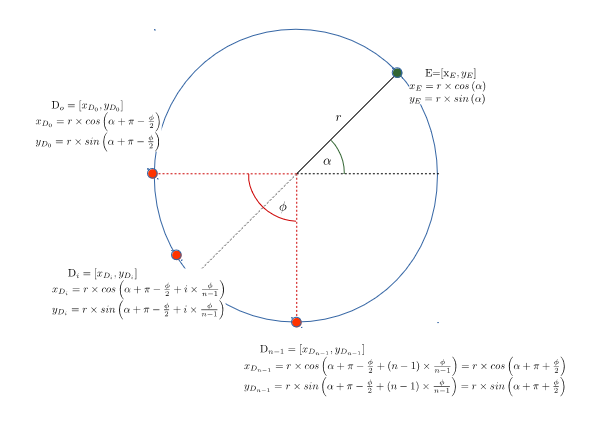
<br>
#### Choose parameters

In [6]:
delta = 0.5
phi = 250
img = images['Kropka']
detector_num = 500

In [7]:
@interact
def set_parameters(_image=list(images.keys()),
                    _detectors=widgets.IntSlider(min=100,max=1000,step=100,value=500),
                    _phi=widgets.IntSlider(min=30,max=300,step=30,value=180),
                    _delta=widgets.IntSlider(min=0.1,max=5,step=0.1,value=1)):
    global delta, phi, detector_num, img
    delta = _delta
    phi = _phi
    detector_num = _detectors
    img = images[_image]
    
    plt.imshow(images[_image], cmap='gray')
    

interactive(children=(Dropdown(description='_image', options=('CT_ScoutView', 'Kolo', 'Kwadraty2', 'SADDLE_PE-…

#### Run radon transform

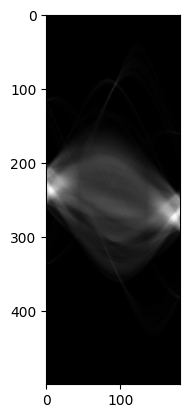

In [8]:
x0, y0 = img.shape[0] // 2, img.shape[1] // 2 # center coordinates
angles = np.arange(0, 180 + delta, delta)
sinogram = np.zeros((len(angles), detector_num))
r = img.shape[0] / 2

for i, alpha in enumerate(angles):
    angles_det = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2)
    angles_emit = np.deg2rad(np.linspace(0, phi, detector_num) + alpha - phi/2 + 180)

    detectors = np.zeros((detector_num, 2), dtype=int)
    emitters = np.zeros((detector_num, 2), dtype=int)
    
    for j, (angle_det, angle_emit) in enumerate(zip(angles_det, angles_emit)):
        xd = np.round(r * np.cos(angle_det) - x0).astype(int)
        yd = np.round(r * np.sin(angle_det) - y0).astype(int)
        xe = np.round(r * np.cos(angle_emit) - x0).astype(int)
        ye = np.round(r * np.sin(angle_emit) - y0).astype(int)
        detectors[j][0], detectors[j][1] = xd, yd
        emitters[detector_num-j-1][0], emitters[detector_num-j-1][1] = xe, ye

    pixels = np.zeros(detector_num, None)
    for j, (det_coord, emit_coord) in enumerate(zip(detectors, emitters)):
        beam_coord = bresenham(tuple(det_coord), tuple(emit_coord))
        pixels[j] = np.sum([img[coord] for coord in beam_coord])

    sinogram[i,] = pixels
    plt.imshow(sinogram.T, cmap='gray')
    plt.show()
    IPython.display.clear_output(wait=True)


#### Run inverse radon transform (TODO)

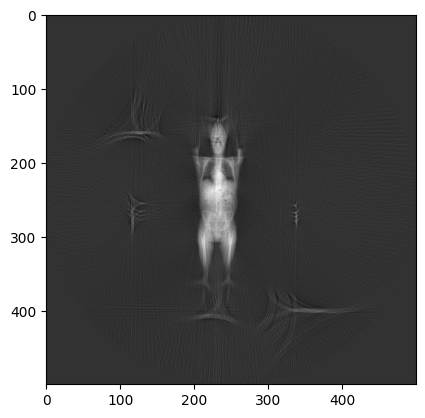

In [9]:
from skimage.transform import iradon
reconstructed_img = iradon(sinogram.T)
plt.imshow(reconstructed_img, cmap='gray')
plt.show()

In [10]:
# http://rknet.pl/student/2013_2014/pom/wyk/POM_Radon_Hough.pdf
# https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html